# Explainability for Deep Learning Forecasting Models

In this detailed tutorial, we discover how to explain forecasts made with models from *neuralforecast*. 

Note that the functionality is currently in beta. It can only be applied on univariate models, but support for multivariate models is coming soon.


## Prerequisites

- We assume you have *neuralforecast* already installed. 
- Explanations are obtained with [Captum](https://captum.ai/): an open-source library for model interpretability in PyTorch. Make sure to install the package with `pip install captum` to use the features demonstrated below. 
- You can optionally install [SHAP](https://shap.readthedocs.io/en/latest/) to access their visualizations capabilities. This can be done with `pip install shap`.

## Load libraries

In [2]:
%%capture

import numpy as np
import pandas as pd
import torch

from neuralforecast.core import NeuralForecast
from neuralforecast.models import NHITS
from neuralforecast.losses.pytorch import MQLoss
from neuralforecast.utils import AirPassengersPanel, AirPassengersStatic

In [3]:
# Set random seeds for reproducibility
np.random.seed(42);
torch.manual_seed(42);

## Load the data

We demonstrate the explainability capabilities with the AirPassengers dataset. This dataset has:
- 2 unique series
- a future exogenous variable (`trend`)
- a historical exogenous variable (`y_lag[12]`)
- static exogenous variable (`Airline1`)

That way, we see that we can handle attributions for all types of exogenous features. For more information on the types of exogenous features, read [this tutorial](https://nixtlaverse.nixtla.io/neuralforecast/docs/capabilities/exogenous_variables.html). 

In [4]:
Y_train_df = AirPassengersPanel[AirPassengersPanel['ds'] < AirPassengersPanel['ds'].values[-12]].reset_index(drop=True)
Y_test_df = AirPassengersPanel[AirPassengersPanel['ds'] >= AirPassengersPanel['ds'].values[-12]].reset_index(drop=True)
futr_df = Y_test_df.drop(columns=["y", "y_[lag12]"])

## Basic usage
### Train a model

Before explaining forecasts, we need to train a forecasting model. Here, we use the NHITS model, but you can use any univariate model. For now, we don't support multivariate models just yet, this feature will be implemented soon.

In [5]:
%%capture

models = [
    NHITS(
        h=12,
        input_size=24,
        hist_exog_list=["y_[lag12]"],
        futr_exog_list=["trend"],
        stat_exog_list=['airline1'],
        max_steps=20,
        scaler_type="robust",
    ),
]

nf = NeuralForecast(
    models=models, 
    freq="ME", 
)

nf.fit(
    df=Y_train_df,
    static_df=AirPassengersStatic
)

### Get features attributions

Once the model is trained, we can get feature attributions using the `nf.explain` method.

This method takes the following parameters:
- `horizons`: List of horizons to explain. If None, all horizons are explained. Defaults to None.
- `outputs`: List of outputs to explain for models with multiple outputs. Defaults to [0] (first output). This is useful when we have models trained with a probabilistic loss. We will explore that later in the tutorial.
- `explainer`: Name of the explainer to use. Options are 'IntegratedGradients', 'ShapleyValueSampling', 'Lime', 'KernelShap', 'InputXGradient'. Defaults to 'IntegratedGradients'.
- `df` (pandas, polars or spark DataFrame): DataFrame with columns [`unique_id`, `ds`, `y`] and exogenous variables. If a DataFrame is passed, it is used to generate forecasts. Defaults to None.
- `static_df` (pandas, polars or spark DataFrame): DataFrame with columns [`unique_id`] and static exogenous. Defaults to None. Only use it if you trained your model with static exogenous features.
- `futr_df` (pandas, polars or spark DataFrame): DataFrame with [`unique_id`, `ds`] columns and `df`'s future exogenous. Defaults to None. Only use it if you trained your model with future exogenous features.
- `verbose`: Print warnings. Defaults to True.
- `engine`: Distributed engine for inference. Only used if df is a spark dataframe or if fit was called on a spark dataframe.
- `level`: Confidence levels between 0 and 100. Defaults to None.
- `quantiles`: Alternative to level, target quantiles to predict. Defaults to None.
- `data_kwargs`: Extra arguments to be passed to the dataset within each model.

Note that parameters from `df` and onwards act exactly the same way as in the `nf.predict()` method. 

In this case, let's explain each horizon step, so we keep `horizons=None`. Since our model used a point loss, there is only one output, so we also keep the default value `outputs=[0]`. Finally, we choose the "IntegratedGradients" explainer, as it is one of the fastest method for interpretability in deep learning.

In [6]:
%%capture

preds_df, explanations = nf.explain(
    static_df=AirPassengersStatic,
    futr_df=futr_df, 
    explainer="IntegratedGradients"
)

We can see that `nf.explain()` returns two values:

1. A dataframe with the forecasts from the fitted models
2. A dictionary with the feature attributions for each model

Thus, you can access the attribution score of each features used for training the NHITS model by accessing `explanations["NHITS"]`. Note that if you used an alias when initializing the model, then the key is the value of the alias.

In [7]:
explanations["NHITS"].keys()

dict_keys(['insample', 'futr_exog', 'hist_exog', 'stat_exog', 'baseline_predictions'])

From above, we can see that we have stored the attributions for each feature type as well as the baseline predictions.
- `insample` contains the attributions for past lags and availability mask
- `futr_exog` contains the attributions for future exogenous features
- `hist_exog` contains the attributions for historical exogenous features
- `stat_exog` contains the attributions for static exogenous features
- `baseline_predictions` contains the baseline prediction of the model if none of the features above were available. Note that if the selected explainer does not have the additivity property, the value will be set to None.

We will touch upon the additivity property in a later section. For now, just know that `IntegratedGradients` has the additive property, meaning that taking the sum of baseline predictions and feature attributions results in the final forecast made by the model.

Now, because we are using Captum, we work directly with tensors, keeping the entire process fast, efficient, and allowing us to leverage GPUs when available. As such, the attributions are also stored as tensors as shown below.

In [8]:
for key in list(explanations["NHITS"].keys()):
    print(f"Shape of {key}: {explanations['NHITS'][key].shape}")

Shape of insample: torch.Size([2, 12, 1, 1, 24, 2])
Shape of futr_exog: torch.Size([2, 12, 1, 1, 36, 1])
Shape of hist_exog: torch.Size([2, 12, 1, 1, 24, 1])
Shape of stat_exog: torch.Size([2, 12, 1, 1, 1])
Shape of baseline_predictions: torch.Size([2, 12, 1, 1])


For each element above, the shape is defined as:

- `insample`: [batch_size, horizon, n_series, n_output, input_size, 2 (y attribution, mask attribution)]
- `futr_exog`: [batch_size, horizon, n_series, n_output, input_size+horizon, n_futr_features]
- `hist_exog`: [batch_size, horizon, n_series, n_output, input_size, n_hist_features]
- `stat_exog`: [batch_size, horizon, n_series, n_output, n_static_features]
- `baseline_predictions`: [batch_size, horizon, n_series, n_output]

Here, `batch_size` is 2 for all, because we are explaining two different series. `n_series` however is 1 because NHITS is a univariate model. Also note that for `insample`, the last shape is always 2, because we score the attribution of the values of the past lags and their availability.

At this point, we have all the information needed to analyze the attribution scores and make visualizations.

### Plotting feature attributions

You can now use any method you want to plot feature attributions. You can make plots manually using any visualization library like `matplotlib` or `seaborn`, but `shap` has dedicated plots for explainability, so let's see how we can use them.

Basically, with the information we have, we can easily create a `shap.Explanation` object that can then be used to create different plots from the `shap` package.

Specifically, a `shap.Explanation` object needs:
- `values`: the attribution scores
- `base_values`: the baseline predictions of the model
- `feature_names`: a list to display nice feature names

Here, let's create a waterfall plot to visualize the attributions of each features, for the first series (Airline1), and for the first step in the horizon. 

In [9]:
import shap

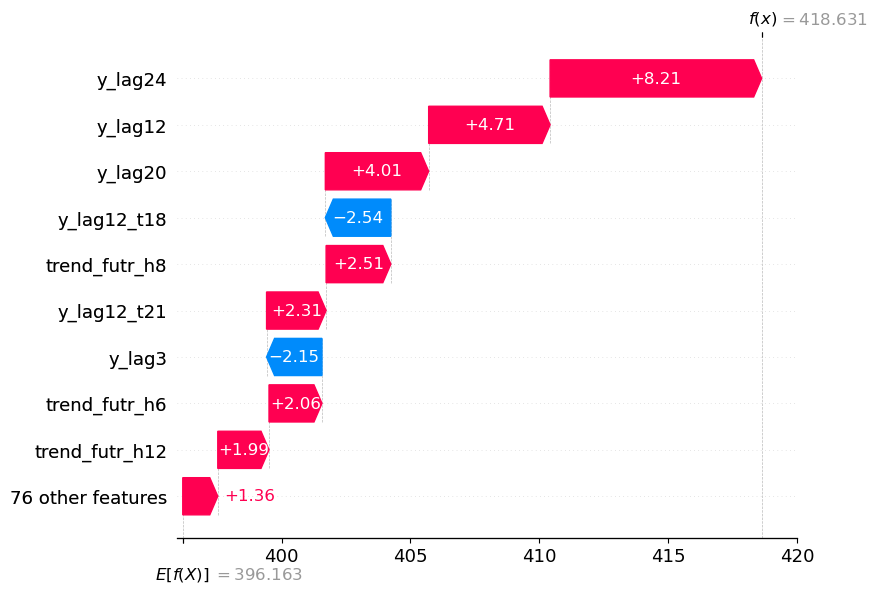

In [10]:
batch_idx = 0    # Attributions for the first series (Airline1)
horizon_idx = 0  # Attributions for the first horizon step
output_idx = 0

attributions = []
feature_names = []

# Insample attributions
y_attr = explanations["NHITS"]["insample"][batch_idx, horizon_idx, 0, output_idx, :, 0]
mask_attr = explanations["NHITS"]["insample"][batch_idx, horizon_idx, 0, output_idx, :, 1]
combined_insample = (y_attr + mask_attr).cpu().numpy()
for i, attr in enumerate(combined_insample):
    attributions.append(attr)
    feature_names.append(f"y_lag{i+1}")

# hist_exog attributions
hist_attr = explanations["NHITS"]["hist_exog"][batch_idx, horizon_idx, 0, output_idx]
hist_attr = hist_attr.cpu().numpy()
for t in range(hist_attr.shape[0]):
    attributions.append(hist_attr[t, 0])
    feature_names.append(f"y_lag12_t{t+1}")

# futr_exog attributions
futr_attr = explanations["NHITS"]["futr_exog"][batch_idx, horizon_idx, 0, output_idx]
futr_attr = futr_attr.cpu().numpy()
for t in range(futr_attr.shape[0]):
    attributions.append(futr_attr[t, 0])
    if t < 24:
        feature_names.append(f"trend_hist_t{t+1}") # Known values in the past
    else:
        feature_names.append(f"trend_futr_h{t-23}") # Knwon values in the future

# stat_exog attributions
stat_attr = explanations["NHITS"]["stat_exog"][batch_idx, horizon_idx, 0, output_idx]
attributions.append(float(stat_attr.cpu()))
feature_names.append("airline1")

shap_values = np.array(attributions)

# baseline_predictions
baseline = float(explanations["NHITS"]["baseline_predictions"][batch_idx, horizon_idx, 0, output_idx].cpu())

# Create SHAP Explanation
shap_explanation = shap.Explanation(
    values=shap_values,
    base_values=baseline,
    feature_names=feature_names
)

shap.plots.waterfall(shap_explanation)

As you can see, we now have a nice waterfall plot showing the baseline prediction, E[f(X)] = 396.163, and how each features contributes to the final forecast f(x) = 418.631.

Of course, we can do a wide variery of different plots from `shap`. For example, we can do a simple bar plot as shown below.

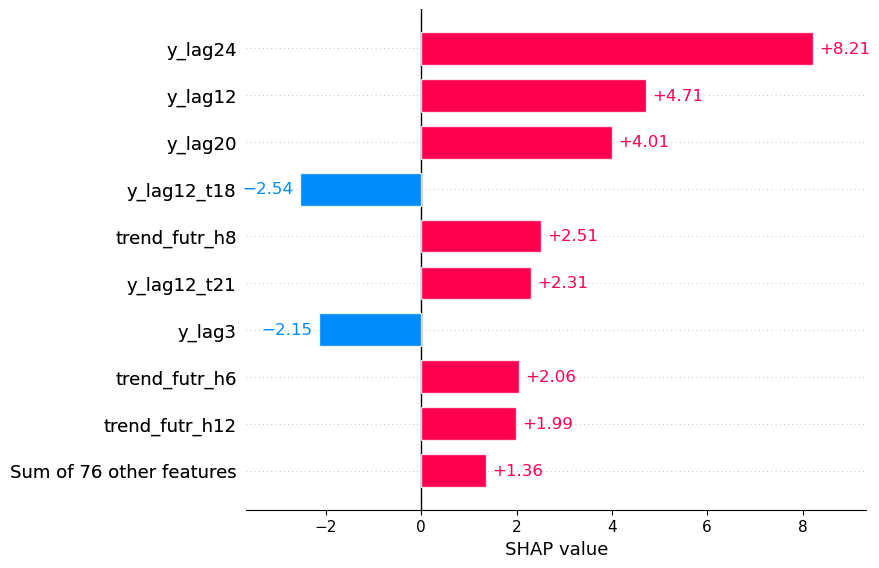

In [11]:
shap.plots.bar(shap_explanation)

In both figures above, we have the breakdown of each feature at each timestep. This can make the plots crowded or it can be a level of granularity that is not necessary for analysis. So, you can also decide to combine all time steps together for a cleaner plot.

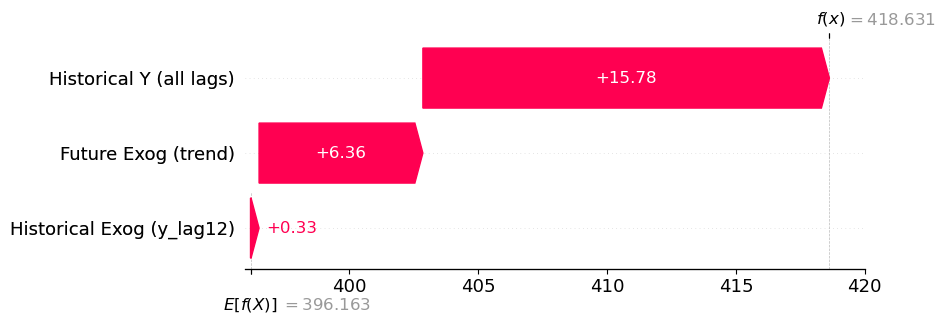

In [12]:
batch_idx = 0
horizon_idx = 0
output_idx = 0

baseline = float(explanations["NHITS"]["baseline_predictions"][batch_idx, horizon_idx, output_idx, output_idx].cpu())
insample_sum = float(explanations["NHITS"]["insample"][batch_idx, horizon_idx, output_idx, output_idx, :, :].sum().cpu())

futr_exog_sum = 0
futr_exog_sum = float(explanations["NHITS"]["futr_exog"][batch_idx, horizon_idx, output_idx, output_idx, :, :].sum().cpu())

hist_exog_sum = 0
hist_exog_sum = float(explanations["NHITS"]["hist_exog"][batch_idx, horizon_idx, output_idx, output_idx, :, :].sum().cpu())

stat_exog_sum = 0
stat_exog_sum = float(explanations["NHITS"]["stat_exog"][batch_idx, horizon_idx, output_idx, output_idx, :].sum().cpu())

feature_names = []
shap_values = []

if insample_sum != 0:
    feature_names.append("Historical Y (all lags)")
    shap_values.append(insample_sum)

if hist_exog_sum != 0:
    feature_names.append("Historical Exog (y_lag12)")
    shap_values.append(hist_exog_sum)

if futr_exog_sum != 0:
    feature_names.append("Future Exog (trend)")
    shap_values.append(futr_exog_sum)

if stat_exog_sum != 0:
    feature_names.append("Static (airline1)")
    shap_values.append(stat_exog_sum)

shap_values = np.array(shap_values)

# Create SHAP Explanation
shap_explanation = shap.Explanation(
    values=shap_values,
    base_values=baseline,
    feature_names=feature_names
)

shap.plots.waterfall(shap_explanation)

As you can see from the plot above, we have combined all inputs of each type of feature into a single category, so we can see how each overall feature contributes to the final forecast.

### Verifying additivity

As mentioned above, "IntegratedGradients" has the additive property, meaning that when we sum the baseline predictions with the total attribution scores of each features, we get the final forecasts made by the model.

In [13]:
attribution_predictions = []

# Process each series
for batch_idx in range(2):  # 2 series
    # Process each horizon for this series
    for horizon_idx in range(12):  # horizon = 12
        # Get baseline
        baseline = float(explanations["NHITS"]["baseline_predictions"][batch_idx, horizon_idx, 0, 0].cpu())
        
        # Sum all attribution components
        total_attr = 0
        
        # Insample (y + mask)
        insample_attr = explanations["NHITS"]["insample"][batch_idx, horizon_idx, 0, 0, :, :].sum()
        total_attr += float(insample_attr.cpu())
        
        # Historical exogenous
        if explanations["NHITS"]["hist_exog"] is not None:
            hist_attr = explanations["NHITS"]["hist_exog"][batch_idx, horizon_idx, 0, 0, :, :].sum()
            total_attr += float(hist_attr.cpu())
        
        # Future exogenous
        if explanations["NHITS"]["futr_exog"] is not None:
            futr_attr = explanations["NHITS"]["futr_exog"][batch_idx, horizon_idx, 0, 0, :, :].sum()
            total_attr += float(futr_attr.cpu())
        
        # Static exogenous
        if explanations["NHITS"]["stat_exog"] is not None:
            stat_attr = explanations["NHITS"]["stat_exog"][batch_idx, horizon_idx, 0, 0, :].sum()
            total_attr += float(stat_attr.cpu())
        
        # Compute final prediction from attributions
        pred_from_attr = baseline + total_attr
        attribution_predictions.append(pred_from_attr)

# Add as new column to preds_df
preds_df['NHITS_attribution'] = attribution_predictions

In [14]:
np.testing.assert_allclose(
    preds_df['NHITS'].values,
    preds_df['NHITS_attribution'].values,
    rtol=1e-3,
    err_msg="Attribution predictions do not match model predictions"
)

From the code above, we can see that reconstructed forecasts from the baseline predictions and attributions are within 0.1% of the original forecasts, so additivity is verified.

## Advanced concepts
### Choosing an explainer

In this section, we outline the different explainers supported in *neuralforecast*. Different algorithms will produce different attribution scores, and so we must choose which applies best to our scenario.

| Explainer | Local/Global | Additivity Property | Speed |
|-----------|--------------|-------------------|-------|
| Integrated Gradients | Local | Yes | Fast |
| Shapley Value Sampling | Local | Yes | Very slow |
| Input X Gradient | Local | No | Very fast |

**Notes:**
- **Local/Global**: All explainers are local, because they only explain how a specific input affects a specific forecast.
- **Additivity Property**: Whether the sum of the feature attributions and baseline predictions result in the final forecast.
- **Speed**: 
  - Very fast: Single gradient computation
  - Fast: Multiple gradient computations (Integrated Gradients)
  - Medium: Multiple model evaluations
  - Slow: Many model evaluations for sampling-based methods
  - Very Slow: Exponential complexity in worst case (exact Shapley values)

#### Integrated Gradients

Integrated Gradients computes attributions by integrating gradients along the straight-line path from a chosen baseline input (e.g., black image, zero embedding) to the actual input. The method calculates the path integral, which is approximated using a Riemann sum with typically 20-300 gradient computations. Learn more in the [original paper](https://arxiv.org/pdf/1703.01365).

**Advantages**
- Theoretically grounded: Satisfies the axioms of sensitivity (features that affect the output get non-zero attribution) and implementation invariance (functionally equivalent networks produce identical attributions)
- Has the additivity property

**Disadvantages**
- Relies on choosing an appropriate baseline that represents "absence of signal". By default, we use a input only 0 values.

#### Shapley Value Sampling
Shapley Value Sampling approximates Shapley values using Monte Carlo sampling of feature permutations. The method randomly samples different orderings of features and computes how much each feature contributes by comparing model predictions when that feature is included versus excluded from the subset. The approach simulates "missing" features by drawing random values from the training data distribution. Learn more in the [original paper](https://www.sciencedirect.com/science/article/abs/pii/S0305054808000804).

**Advantages**
- All subsets of input features are perturbed, so interactions and redundancies between features are taken into account
- Uses simple permutation sampling that is easy to understand

**Disadvantages**
- High computational cost: requires many model evaluations (typically hundreds to thousands) to achieve reasonable approximation accuracy
- Very slow due to the high number of model evaluations
- Simulates missing features by sampling from marginal distributions, which may create unrealistic data instances when features are correlated

#### Input X Gradient
Input X Gradient computes feature attribution by simply multiplying each input value by the gradient of the model output with respect to that input. This corresponds to a first-order Taylor approximation of how the output would change if the input were set to zero. This means each time step's input values are multiplied by the gradients to show which historical observations most influence the prediction. Learn more in the [original paper](https://arxiv.org/pdf/1605.01713).

**Advantages**
- Computational efficiency: it requires only a single pass through the model
- No approximations as it uses the gradient of the model

**Disadvantages**
- No additivity
- A bit problematic with the ReLu function, because their gradient can be 0, but it can still carry some information
- Functions like tanh or sigmoid can have very low gradients, even though the input is significant, so it's problematic for LSTM and GRU models.

### Explaining models with different loss functions

Currently, explanations are supported for models trained with:
- Point loss functions (MAE, MSE, RMSE, etc.)
- Non-parametric probabilistic losses (IQLoss, MQLoss, etc.)

We do not support yet explaining models trained with parametric loss functions, like Normal, Student's T, etc.

For more information on the different loss functions supported in *neuralforecast*, read [here](https://nixtlaverse.nixtla.io/neuralforecast/docs/capabilities/objectives.html).

#### Explaning a model with a probablistic loss function
If you are explaining a model with a non-parametric loss function, then by default, we only explain the median forecast. This is controlled by the `ouputs` parameter. Let's see an example.

In [15]:
%%capture

# Initialize model
models = [
    NHITS(
        h=12,
        input_size=24,
        hist_exog_list=["y_[lag12]"],
        futr_exog_list=["trend"],
        stat_exog_list=['airline1'],
        loss=MQLoss(level=[80]),
        max_steps=20,
        scaler_type="robust",
    ),
]

nf = NeuralForecast(
    models=models, 
    freq="ME", 
)

# Fit model
nf.fit(
    df=Y_train_df,
    static_df=AirPassengersStatic
)

# Get predictions and attributions
preds_df, explanations = nf.explain(
    outputs=[0], # Explain only the median forecast
    static_df=AirPassengersStatic,
    futr_df=futr_df, 
    explainer="IntegratedGradients"
)

Above, by specifying `outputs=[0]`, which is the default value, we only explain the median forecast. However, we can explain up to three ouputs:
1. Median forecast
2. Lower bound
3. Upper bound

As such, to explain all outputs, we must set `ouputs=[0,1,2]`.

In [16]:
%%capture

preds_df, explanations = nf.explain(
    outputs=[0, 1, 2], # Explain all outputs
    static_df=AirPassengersStatic,
    futr_df=futr_df, 
    explainer="IntegratedGradients"
)

In [17]:
for key in list(explanations["NHITS"].keys()):
    print(f"Shape of {key}: {explanations['NHITS'][key].shape}")

Shape of insample: torch.Size([2, 12, 1, 3, 24, 2])
Shape of futr_exog: torch.Size([2, 12, 1, 3, 36, 1])
Shape of hist_exog: torch.Size([2, 12, 1, 3, 24, 1])
Shape of stat_exog: torch.Size([2, 12, 1, 3, 1])
Shape of baseline_predictions: torch.Size([2, 12, 1, 3])


As you can see, the fourth dimension, which represents the number of ouputs, is now equal to 3, because we are explaining the median, the lower bound and upper bound.

### Explaining models with a scaler (`local_scaler_type`)

If you specify a `local_scaler_type` in your `NeuralForecast` object, note that the attribution scores will be scaled. This is because the data is scaled before the training process. The relative importance is still relevant, but note that additivity will not hold.

If additivtiy is important, then you must use `scaler_type` when initializing the model, as we do in this tutorial. This scales each window of data during training, so we can easily inverse transform the attribution scores.

Again, no matter which approach you choose, the relative attribution scores are still valid and comparable. It's only additivity that is impacted. If you specify a `local_scaler_type`, then a warning is issued about additivity.

### Explaining recurrent models

You can explain recurrent models (LSTM, GRU). Just note that if you set `recurrent=True`, then the Integrated Gradients explainer is not supported. If `recurrent=False`, you can use any explainer.

## References

M. Sundararajan, A. Taly, and Q. Yan, “Axiomatic Attribution for Deep Networks.” Available: https://arxiv.org/pdf/1703.01365

S. Lundberg, P. Allen, and S.-I. Lee, “A Unified Approach to Interpreting Model Predictions,” Nov. 2017. Available: https://arxiv.org/pdf/1705.07874

J. Castro, D. Gómez, and J. Tejada, “Polynomial calculation of the Shapley value based on sampling,” Computers & Operations Research, vol. 36, no. 5, pp. 1726–1730, May 2009, doi: https://doi.org/10.1016/j.cor.2008.04.004.

A. Shrikumar, P. Greenside, A. Shcherbina, and A. Kundaje, “Not Just a Black Box: Learning Important Features Through Propagating Activation Differences,” arXiv:1605.01713 [cs], Apr. 2017, Available: https://arxiv.org/abs/1605.01713